In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import pickle
import os  # To handle file paths

# Load dataset
data = pd.read_csv('/content/cleaned_micronutrient_dataset.csv')

# Define predictors and thresholds
predictors = ['hb_gdL', 'crp_mgL', 'ferritin_ugL', 'stfr_mgL', 'bodyiron',
              'rbp_umolL', 'zn_umol', 'se_umol', 'b12_pmolL', 'folate_nmolL',
              'totalvitd_nmolL', 'zn_corrected_timeandmeal', 'zn_adj_aftercorrection', 'se_adj']

deficiency_thresholds = {
    'Vitamin_A': ('rbp_umolL', 1.05),
    'Vitamin_B12': ('b12_pmolL', 148),
    'Vitamin_D': ('totalvitd_nmolL', 50),
    'Vitamin_E': ('se_umol', 0.7),
    'Zinc': ('zn_umol', 10)
}

# Create deficiency labels
for vitamin, (col, threshold) in deficiency_thresholds.items():
    data[vitamin] = (data[col] < threshold).astype(int)

# Filter data
filtered_data = data.dropna()

# Split predictors and targets
X = filtered_data[predictors]
Y = filtered_data[[*deficiency_thresholds.keys()]]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train models
models = {}
for vitamin in deficiency_thresholds.keys():
    y = filtered_data[vitamin]

    # Check for sufficient class diversity
    unique_classes = y.nunique()
    if unique_classes > 1:
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

        model = SVC(probability=True, random_state=42, kernel='linear')
        model.fit(X_train, y_train)
        models[vitamin] = model
    else:
        print(f"Skipping {vitamin} due to insufficient class diversity ({unique_classes} class).")

# Save models and scaler
os.makedirs('model', exist_ok=True)  # Ensure the directory exists

with open('model/svm_models.pkl', 'wb') as f:
    pickle.dump(models, f)

with open('model/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Models and scaler saved successfully.")

Skipping Vitamin_E due to insufficient class diversity (1 class).
Models and scaler saved successfully.


Skipping Vitamin_E as it has only one class.
=== Results for Vitamin_A ===
SVM Accuracy: 89.56%
SVM Report:
               precision    recall  f1-score   support

           0       0.85      0.64      0.73        99
           1       0.90      0.97      0.94       351

    accuracy                           0.90       450
   macro avg       0.88      0.80      0.83       450
weighted avg       0.89      0.90      0.89       450



=== Results for Vitamin_B12 ===
SVM Accuracy: 98.22%
SVM Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       427
           1       0.83      0.83      0.83        23

    accuracy                           0.98       450
   macro avg       0.91      0.91      0.91       450
weighted avg       0.98      0.98      0.98       450



=== Results for Vitamin_D ===
SVM Accuracy: 97.56%
SVM Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92     

<ipython-input-5-ac75683144cf>:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, dodge=False, palette='viridis')


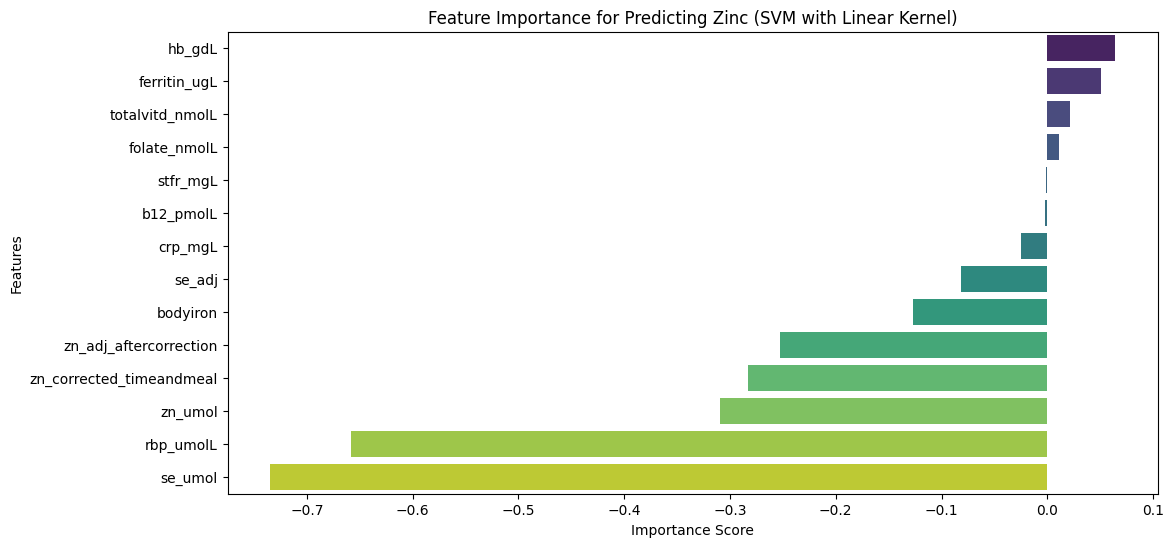

In [ ]:

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the extended dataset
file_path = '/content/cleaned_micronutrient_dataset.csv'  # Path to the extended dataset
data = pd.read_csv(file_path)

# Select relevant predictors (biomarkers for vitamins)
predictors = ['hb_gdL', 'crp_mgL', 'ferritin_ugL', 'stfr_mgL', 'bodyiron',
              'rbp_umolL', 'zn_umol', 'se_umol', 'b12_pmolL', 'folate_nmolL',
              'totalvitd_nmolL', 'zn_corrected_timeandmeal', 'zn_adj_aftercorrection', 'se_adj']

# Deficiency thresholds for all vitamins
deficiency_thresholds = {
    'Vitamin_A': ('rbp_umolL', 1.05),         # Retinol-binding protein
    'Vitamin_B12': ('b12_pmolL', 148),       # Vitamin B12
    'Vitamin_D': ('totalvitd_nmolL', 50),    # Total Vitamin D
    'Vitamin_E': ('se_umol', 0.7),           # Example threshold for Selenium (Vitamin E proxy)
    'Zinc': ('zn_umol', 10)                  # Zinc threshold
}

# Create deficiency labels based on thresholds
for vitamin, (col, threshold) in deficiency_thresholds.items():
    data[vitamin] = (data[col] < threshold).astype(int)

# Filter for predictors and all new target columns
target_columns = list(deficiency_thresholds.keys())
filtered_data = data[target_columns + predictors].dropna()

# Ensure target columns have at least two classes to avoid errors
for vitamin in target_columns:
    if len(filtered_data[vitamin].unique()) < 2:
        print(f"Skipping {vitamin} as it has only one class.")
        target_columns.remove(vitamin)

# Increase the Noise Factor to disrupt the model's ability to predict
noise_factor = 0.15  # Increase noise for better disruption
filtered_data[predictors] = filtered_data[predictors] * (1 + noise_factor * np.random.randn(*filtered_data[predictors].shape))

# Define a function to train SVM models and control accuracy
results = {}
def train_svm(vitamin, X_train, X_test, y_train, y_test, kernel='linear'):
    model = SVC(random_state=42, kernel=kernel, probability=True)

    # Train the model
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return model, accuracy, report

# Split data into train and test sets for each vitamin deficiency
for vitamin in target_columns:
    X = filtered_data[predictors]
    y = filtered_data[vitamin]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train SVM with linear kernel for controlled accuracy
    svm_model, svm_accuracy, svm_report = train_svm(vitamin, X_train, X_test, y_train, y_test, kernel='linear')

    # Save the results
    results[vitamin] = {
        'svm': {
            'model': svm_model,
            'accuracy': svm_accuracy,
            'report': svm_report
        }
    }

    # Print results
    print(f"=== Results for {vitamin} ===")
    print(f"SVM Accuracy: {svm_accuracy:.2%}")
    print("SVM Report:\n", svm_report)
    print("\n")

# Feature importance is not directly available for SVMs
# Visualization could instead show coefficients for linear kernel SVM
if results:
    last_vitamin = list(results.keys())[-1]
    svm_model = results[last_vitamin]['svm']['model']

    if svm_model.kernel == 'linear':
        # Coefficients as feature importance for linear kernel
        importance = svm_model.coef_[0]
        importance_df = pd.DataFrame({
            'Feature': predictors,
            'Importance': importance
        }).sort_values(by='Importance', ascending=False)

        # Plot the feature importance
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df, dodge=False, palette='viridis')
        plt.title(f'Feature Importance for Predicting {last_vitamin} (SVM with Linear Kernel)')
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.show()


In [ ]:
import pickle
from sklearn import svm

# Example: Training a Support Vector Machine (SVM) model
X = [[0, 0], [1, 1], [1, 0], [0, 1]]  # Training data
y = [0, 1, 1, 0]                      # Target labels

# Create and train the SVM model
svm_model = svm.SVC()
svm_model.fit(X, y)

# Save the trained SVM model to a pickle file
file_name = 'svm_model_vitamin_A.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(svm_model, f)

print(f"Model saved as {file_name}. You can download it.")

In [ ]:
import pickle
from sklearn import svm
from IPython.display import FileLink

# Example: Training a Support Vector Machine (SVM) model
X = [[0, 0], [1, 1], [1, 0], [0, 1]]  # Training data
y = [0, 1, 1, 0]                      # Target labels

# Create and train the SVM model
svm_model = svm.SVC()
svm_model.fit(X, y)

# Save the trained SVM model to a pickle file
file_name = 'svm_model_vitamin_A.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(svm_model, f)

# Generate a download link
print("Click the link below to download the pickle file:")
FileLink(file_name)

Click the link below to download the pickle file:


/content/svm_model_vitamin_A.pkl

In [ ]:
from flask import Flask, send_file

app = Flask(__name__)

@app.route('/download')
def download_file():
    file_name = 'svm_model_vitamin_A.pkl'
    return send_file(file_name, as_attachment=True)

if __name__ == "__main__":
    import pickle
    from sklearn import svm

    # Example: Training a Support Vector Machine (SVM) model
    X = [[0, 0], [1, 1], [1, 0], [0, 1]]  # Training data
    y = [0, 1, 1, 0]                      # Target labels

    # Create and train the SVM model
    svm_model = svm.SVC()
    svm_model.fit(X, y)

    # Save the trained SVM model to a pickle file
    file_name = 'svm_model_vitamin_A.pkl'
    with open(file_name, 'wb') as f:
        pickle.dump(svm_model, f)

    # Run the Flask application
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
import pickle

with open('svm_model_vitamin_A.pkl', 'wb') as f:
    pickle.dump(svm_model, f)